In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=11oDZ6JvJS0xP_u_YE55IFoX1C8TzDKQB

Downloading...
From: https://drive.google.com/uc?id=11oDZ6JvJS0xP_u_YE55IFoX1C8TzDKQB
To: /content/train.csv
100% 461k/461k [00:00<00:00, 3.71MB/s]


In [ ]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.4, style='whitegrid')
%config InlineBackend.figure_format='retina'

В учебных целях в первой задаче запрещено использовать готовые реализации линейной регрессии (например, из пакета *scikit-learn*).

## Задача 1 (10 баллов)

На полигоне испытывается новая модель трамвая. В одном из испытании работы двигателя проверяется, что движение трамвая равномерно. Для проведения теста на трамвай установлен датчик, посекундно измеряющий пройденное расстояние. 

Записи датчика можно описать такой моделью:

 $$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$ 
 
где $X_i$ --- расстояние, которое проехал трамвай за $i$ секунд. В модели $\beta_1$ --- начальное расстояние, $\beta_2$ --- скорость трамвая, $\varepsilon_0$ --- ошибка начального показания датчика. Отсчет времени идет от предыдущего замера, причем отсчет происходит с ошибкой. Для $i = 1, \ldots, n$ величина $\varepsilon_i$ есть ошибка приращения расстояния, то есть $\varepsilon_i = \varepsilon_i^t \beta_2,$ где $\varepsilon_i^t$ --- ошибка отсчета времени. Все ошибки $\varepsilon_i$ независимы и распределены по закону $N(0, \sigma^2)$. 

Сведите задачу к линейной модели и найдите оценки наименьших квадратов для начального расстояния $\beta_1$ и скорости $\beta_2,$ а также несмещенную оценку для $\sigma^2,$ из которой выразите оценку дисперсии отсчета времени. 

Данные возьмите из файла Regression.csv. Сделайте выводы.

### Решение

Загрузим датасет, содержащий показания датчика.

In [ ]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1gmSof1yxWt009QoBiKjwkLMlcpn3r61W

Downloading...
From: https://drive.google.com/uc?id=1gmSof1yxWt009QoBiKjwkLMlcpn3r61W
To: /content/regression.csv
100% 9.98k/9.98k [00:00<00:00, 9.31MB/s]


In [ ]:
X = np.genfromtxt('regression.csv')
print('Размер датасета:', X.shape)
print('Средняя скорость:', X[-1] / X.shape[0])

Размер датасета: (1000,)
Средняя скорость: 12.0408175


Датасет состоит из 1000 измерений. По смыслу средняя скорость имеет размерность метры в секунду.

Построим график показаний датчика:

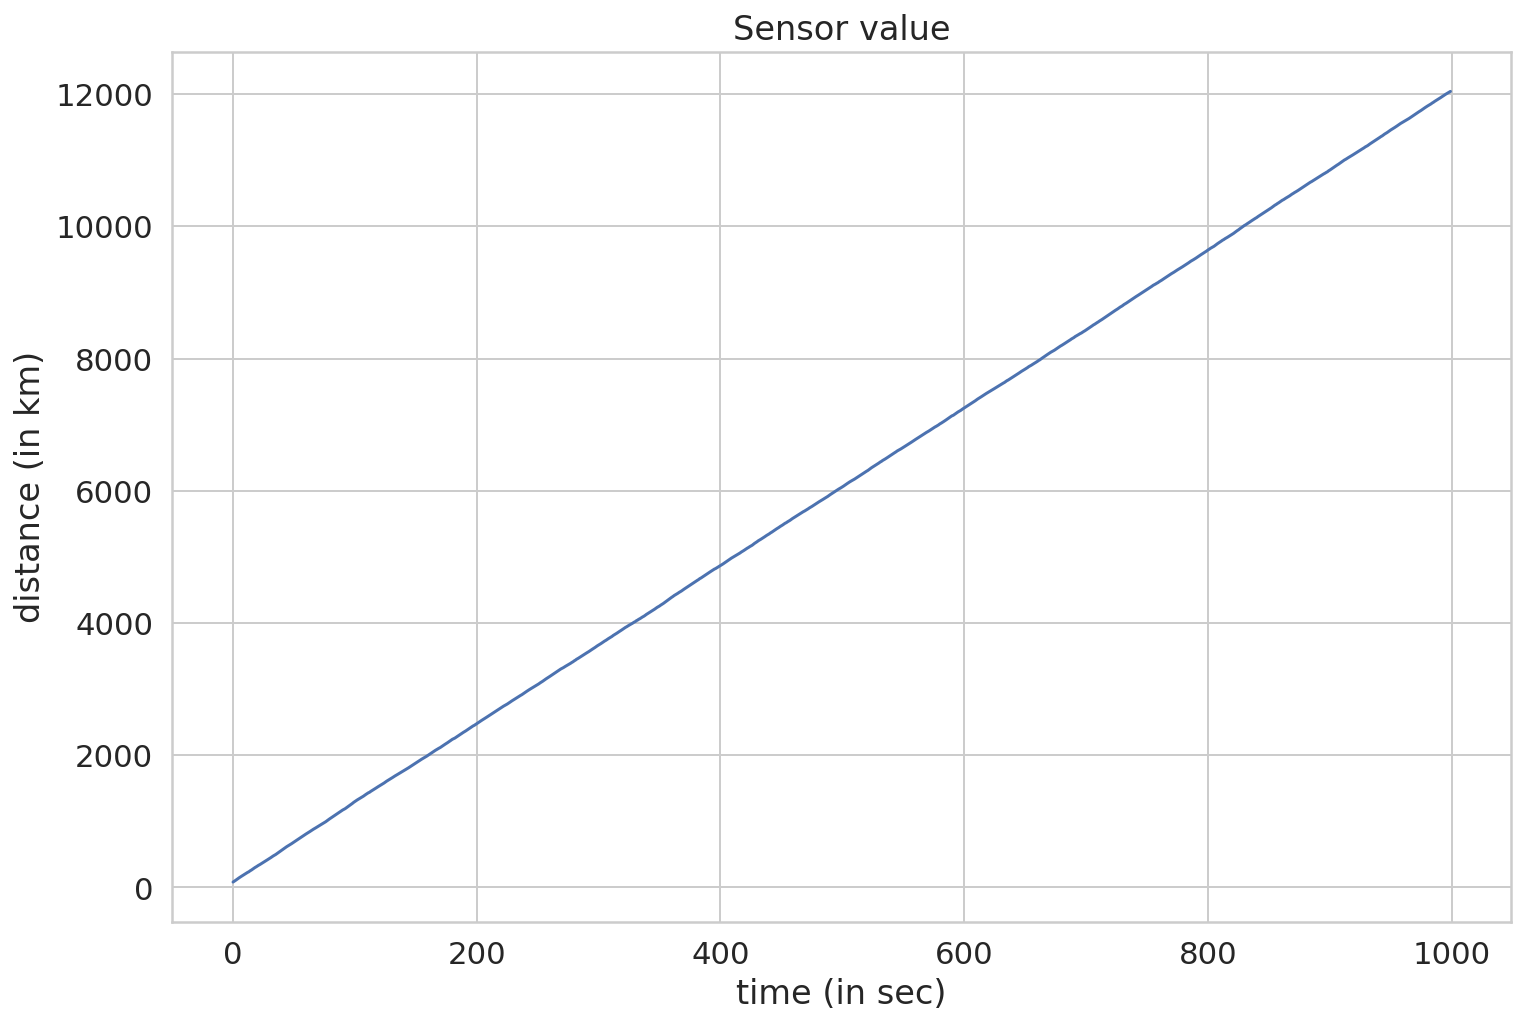

In [ ]:
plt.figure(figsize=(12, 8))
plt.title("Sensor value")
plt.plot(X)
plt.xlabel("time (in sec)")
plt.ylabel("distance (in km)")
plt.show()

Видим, что график линейный. Для оценки параметров $\beta_1$ и $\beta_2$ воспользуемся гауссовской линейной моделью. 

#### 1. Сведем задачу к гауссовской линейной модели

Каким образом свести изначальную задачу к гауссовской линейной модели? Останется ли распредление вектора ошибок тем же? Новый вектор наблюдений назовите $Y$.

Расстояние, которе проехал трамвай за $i$ секунд по показанию датчика: 
$$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n,$$
где $\beta_1$ --- начальное расстояние, $\beta_2$ --- скорость трамвая, $\varepsilon_0$ --- ошибка начального показания датчика.

Эта задача изначально не удовлетворяет требованиям линейной модели, потому что вектор наблюдейний $X$ задан в другом виде, но ее можно свести к линейной регрессии таким образом:
$$ Y = 
\left(\begin{array}{cc} 
X_0 \\
X_1 - X_0 \\
X_2 - X_1 \\
\dots \\
X_n - X_{n-1} \\
\end{array}\right) = 
\left(\begin{array}{cc} 
\beta_1 + \varepsilon_0 \\
\beta_2 + \varepsilon_1 \\
\beta_2 + \varepsilon_2 \\
\dots \\
\beta_2 + \varepsilon_n \\
\end{array}\right),
$$
где вектор $Y$ --- это новый столбец наблюдецний.

Столбец $Y$ представляется в виде $Y = l + \varepsilon$, где $l$ --- это измеряемая величина (состоит из $\beta_1$ и $\beta_2$), а $\varepsilon$ --- ошибка измерения.

Заметим, что при преобразовании $X$ в $Y$ вектор ошибок остался из того же распределения. Изначально ошибки измерений были одинаково распределены: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$, после вычетания, по свойствами нормального распределения получим случайную величину из того же распределения: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$.

In [ ]:
Y = X - np.insert(X, 0, 0)[:X.size]

#### 2. Требования к гауссовской линейной модели

Напомним, что в гауссовской линейной модели наблюдение -- вектор $X \in \mathbb{R}^n$, представимо в виде $X = l + \varepsilon$, где $l$ --- неизвестный случайный вектор (измеряемая величина), $\varepsilon$ --- случайный вектор (ошибка измерения), имеющий распредление $\mathcal{N}(\vec{0}, \sigma^2 I)$. То есть среднее значение ошибки измерения должно быть равно нулю и в нашей модели для всех измерений ошибки должны иметь одинаковую дисперсию (гомоскедастичность).

Проверим, что дисперсия ошибки не меняется со временем

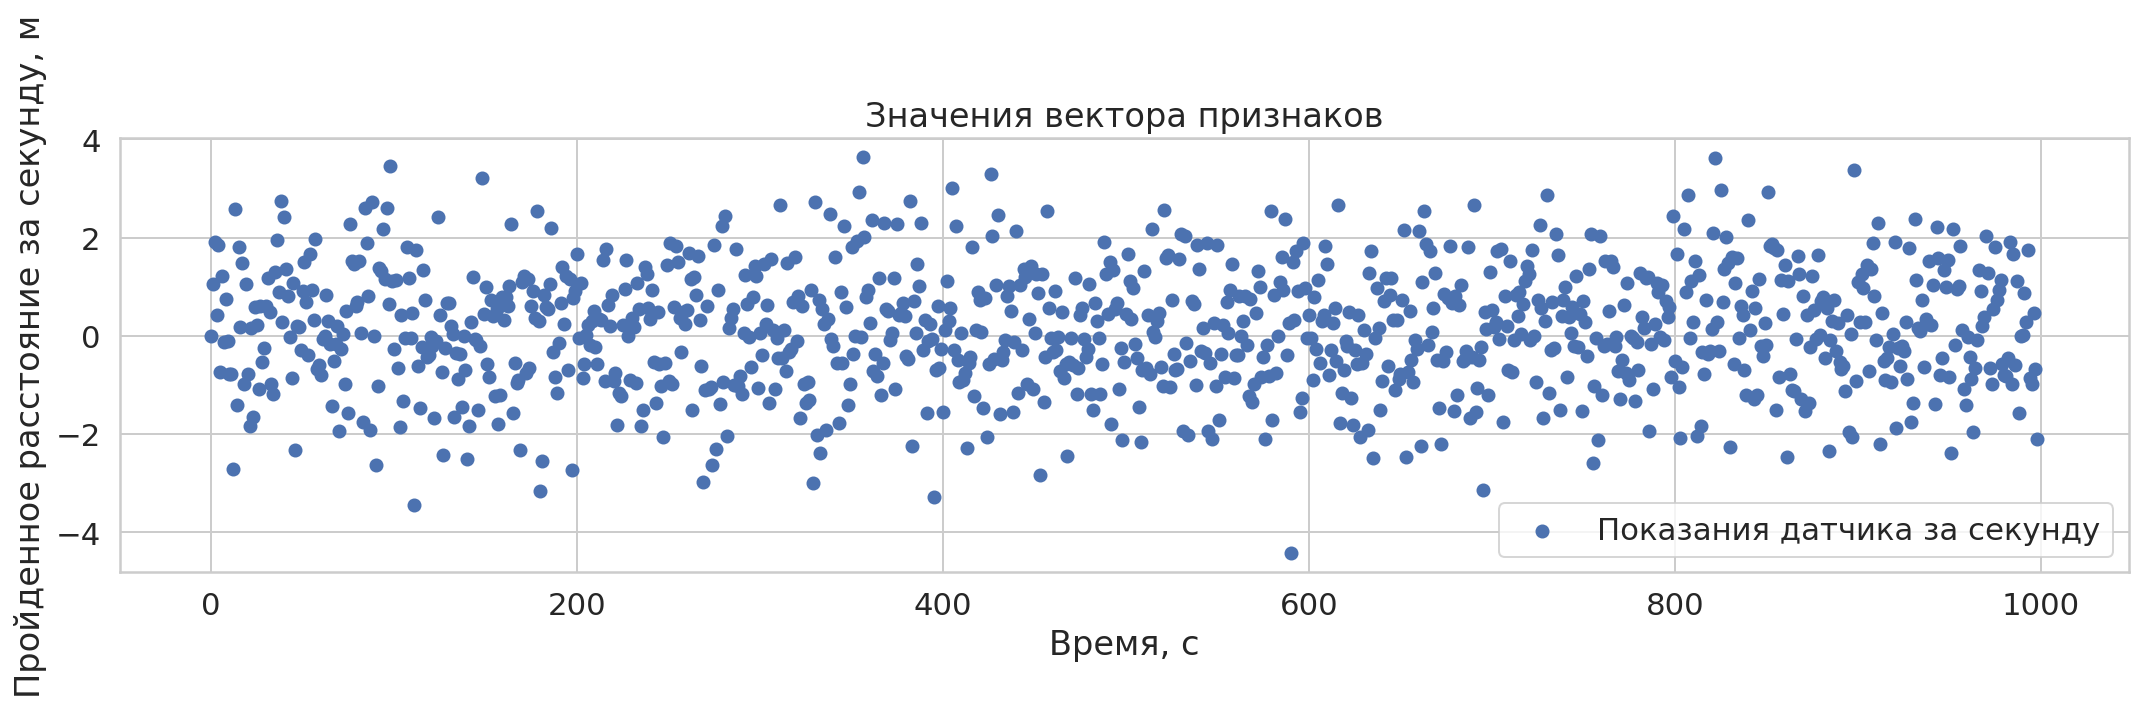

In [ ]:
time = np.arange(Y.shape[0] - 1)
plt.figure(figsize=(18,4))
plt.title("Значения вектора признаков")
plt.scatter(time, Y[1:] - Y[1], label="Показания датчика за секунду")
plt.xlabel("Время, с")
plt.ylabel("Пройденное расстояние за секунду, м")
plt.legend()

plt.show()

Проверим, что ошибка имеет нормальное распределение. Для этого сравним распредление ошибок и теоретическое нормальное распредление с помощбю графика QQ-plot:

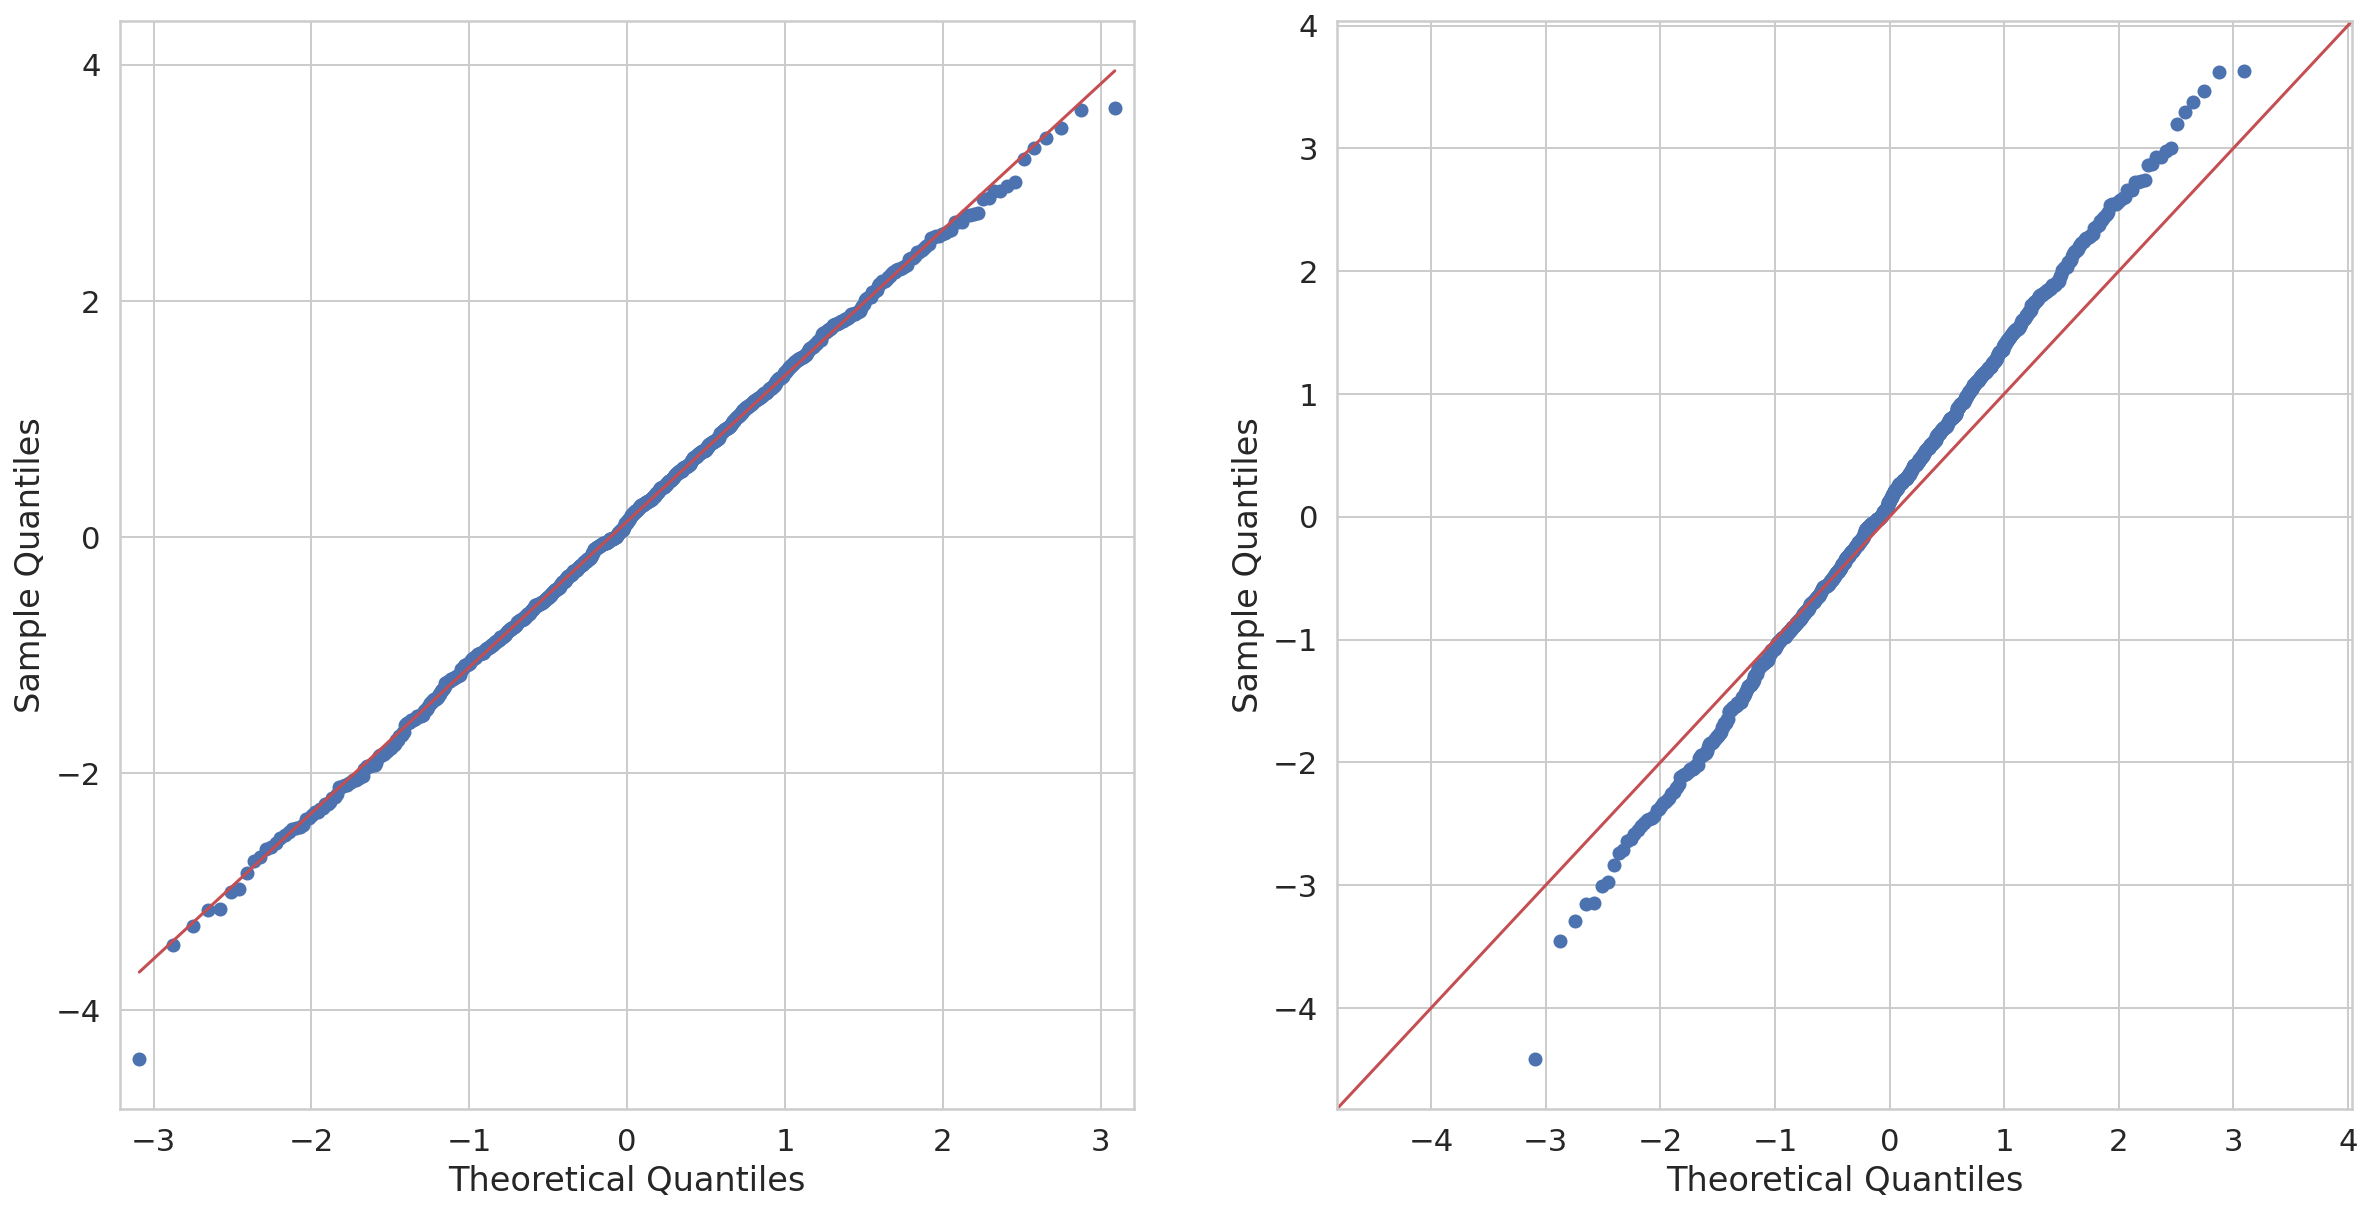

In [ ]:
import statsmodels.api as sm

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# default comparison distribution is standard normal
sm.qqplot(Y[1:] - Y[1], ax=ax[0], line='s')
sm.qqplot(Y[1:] - Y[1], ax=ax[1], line='45')
fig.show()

**Вывод: ошибки действительно имеют нормальное распределение. Также можно заметить, что график "круче" прямой y=x, что говорит о том, что значение дисперсии ошибок больше, чем 1 (т.е. чем значение дисперсии у стандартного нормального распределения)**

#### 3. Оценка параметров

Воспользуйтесь реализованным в начале задания классом `LinearModel`. Как выглядит ваша матрица признаков $Z$? Какие значения параметров $\beta_1$ и $\beta_2$?

Вектор $l$ представляется в виде: $l = Z\theta$, где $\theta$ --- это вектор искомых весов: 
$\theta = 
\left(\begin{array}{cc} 
\beta_1 \\
\beta_2 \\
\end{array}\right)$, матрица признаков $Z = 
\left(\begin{array}{cc} 
1 & 0 \\
0 & 1 \\
\dots & \dots\\
0 & 1 \\
\end{array}\right)$ имеет высоту $n$.

Линейную модель можно представить так: $Y = Z\theta + \varepsilon$.

Оценка $\theta$ методом наименьших квадратов: $$\hat{\theta} = \arg \min_\theta || Y - Z\theta ||^2.$$ Для этой задачи существует аналитическое решение: 

$$\hat{\theta} = (Z^TZ)^{-1}Z^TY.$$

In [ ]:
Z = np.array([1, 0] + [0, 1] * (Y.shape[0] - 1))
Z = Z.reshape((Y.shape[0], 2))

In [ ]:
theta_mse = np.linalg.inv(Z.T @ Z) @ Z.T @ Y
print(theta_mse)

[82.0053     11.97078298]


Итого, получаем,  значения $\beta_1$ и $\beta_2$ -- начальное расстояние и скорость: $\beta_1 = 82.01\ (м), \beta_2 = 11.97\ (м/с)$.

#### 4. Оценка дисперсии ошибки показаний датчика.

Найдите оценку дисперсии $\sigma^2$ показаний датчика $\varepsilon$. После того, как она найдена, найдите оценку дисперсии $\sigma^2$ ошибки отсчёта времени $\varepsilon^t$.

Существует несмещенная оценка $\sigma^2$:
$$\dfrac{1}{n-k}||Y - Z\hat{\theta}||_2^2,$$ где $n$ --- число измерений, $k$ --- размер вектора весов. В нашем случае $n = 1000$ (размер выборки), $k = 2$ (число весов: $\beta_1$ и $\beta_2$).

In [ ]:
sigma_hat = 1/(Y.shape[0] - theta_mse.shape[0]) * (Y - Z @ theta_mse).T @ (Y - Z @ theta_mse)
print("Несмещённая оценка дисперсии линейной модели:", sigma_hat)

Несмещённая оценка дисперсии линейной модели: 1.5252448716139115


Найдём оценку дисперсии ошибки отсчёта времени $\varepsilon_i^t.$ До этого нашли $\varepsilon$ --- ошибка приращения расстояния. Ошибка отсчета времени связана с ошибкой приращения расстояния так: $\varepsilon = \varepsilon^t \beta_2,$ где $\varepsilon^t$ --- ошибка отсчета времени.

Раз $\varepsilon \sim \mathcal{N}(0, \sigma^2)$, то $\varepsilon^t = \varepsilon/\beta_2 \sim \mathcal{N}\left(0, \dfrac{\sigma^2}{\beta_2 ^ 2}\right)$

In [ ]:

print("Оценка дисперсии ошибки отсчёта времени", sigma_hat/theta_mse[1]**2)

Оценка дисперсии ошибки отсчёта времени 0.010643744924922063


#### 5. Измерим качество модели

В качестве метрики качества модели, эксперты предложили использовать [коэффициент детерминанции](https://ru.wikipedia.org/wiki/Коэффициент_детерминации). Он показывает какую долю дисперсии выборки объясняет линейная регрессия. В нашем случае, значение $R^2 > 0.98$ будет означать, что трамвай прошел испытание.

In [ ]:
time = np.arange(X.shape[0]) + 1
res = np.array([theta_mse[0] + theta_mse[1] * time - X])
R = 1 - sigma_hat/np.var(res)
print("R^2 = ", R)

R^2 =  0.9852954754619733


Ответ в задаче:

$\beta_1 = 82.0053$ -- начальное расстояние,

$\beta_2 = 11.9708$ -- скорость движения,

$\sigma^2 = 1.5252$ -- дисперсия отсчета расстояния,

$\sigma_t^2 = 0.0106$ -- дисперсия отсчета времени.

**Вывод: модель хорошо описывает исходные данные. Таким образом, мы установили, что движение трамвая равномерно.**

## Задача 2 (20 баллов)

Теперь давайте попрактикуемся в решении задач на реальных данных. Мы будем анализировать рынок недвижимости 🏘. Данные возьмем из [соревнования](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на платформе kaggle. В отличие от соревнований нас будут интересовать зависимости в данных, а не более точные предсказания.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png).

В частности мы будем смотреть на влияние различных признаков на стоимость дома и проверим несколько гипотез.

In [ ]:
from scipy import stats as sps

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [ ]:
df = pd.read_csv("train.csv")

df.fillna("NA", inplace=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


Можно заметить, что в данных присутствуют категориальные признаки, которые при этом не лишены порядка. Давайте заменим строки на числа, сохранив при этом порядок.

In [ ]:
useful_columns = [
    "OverallQual", 
    "GrLivArea", 
    "ExterQual",
    "KitchenQual",
    "GarageArea",
    "PoolArea",
    "BsmtQual",
    "TotalBsmtSF",
    "GarageFinish",
    "SalePrice"
]

filtered_df = df[useful_columns]

transforms = {
    "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "ExterQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "GarageFinish": {"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3},
}

for column_name, transform in transforms.items():
    filtered_df[column_name] = filtered_df[column_name].apply(lambda x: transform[x])


### Изучение данных

Перед тем, как начать использовать линейные модели необходимо убедиться в том, что столбцы признаков не слишком коллинеарны. Для этого можно использовать корреляцию Пирсона. Используя ``sns.heatmap`` постройте "тепловую карту" попарных корреляций признаков. Для того, чтобы увидеть числовые значения корреляций используйте ``annot=True``. Сделайте размер графика алекватным, например, ``figsize=(11, 10)``.

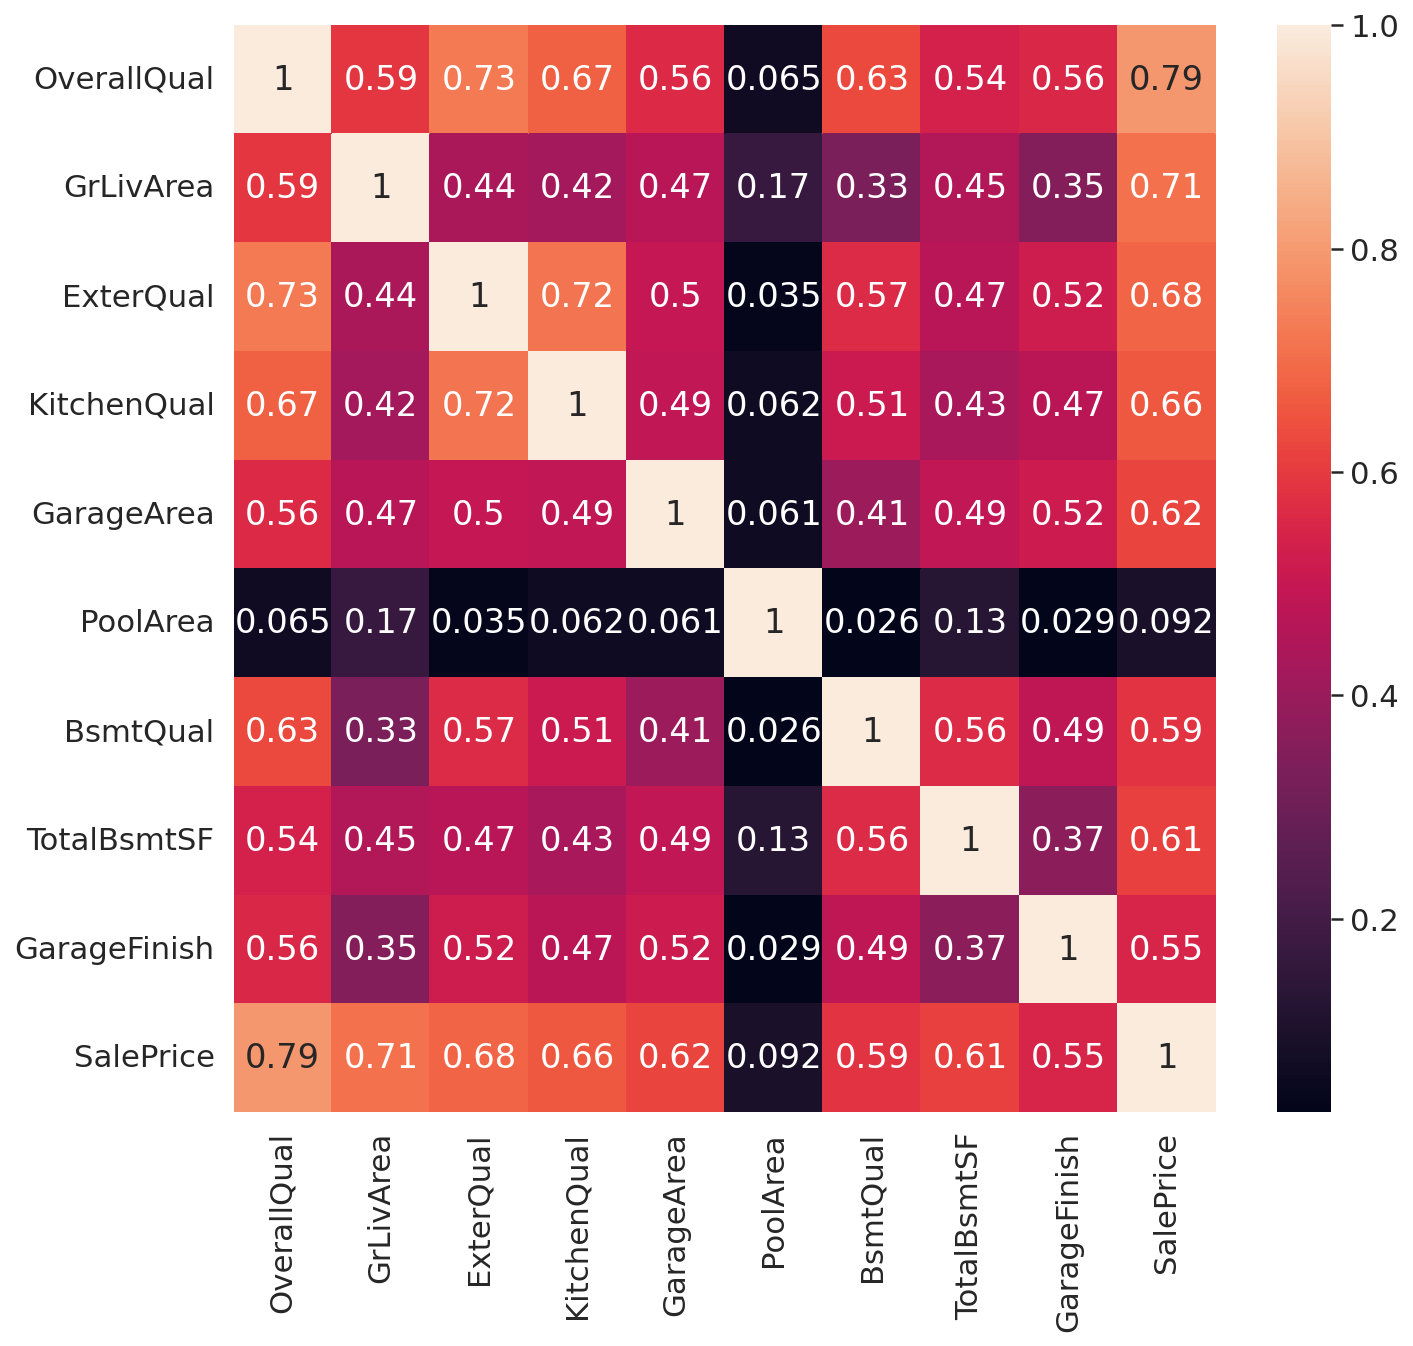

In [ ]:
plt.figure(figsize=(11, 10))
sns.heatmap(filtered_df.corr(), annot = True)
plt.show()

Посмотрите на график выше: есть ли на нем линейно зависимые признаки ($|r_{XY}| > 0.9$)? 

**Ответ:** no.

Удалите, если требуется, один из двух скоррелированных признаков в ячейке ниже.

In [ ]:
filtered_df = filtered_df

Давайте подробнее изучим взаимодействие признаков. Построим матрицу. На диагонале $a_{ii} = d_i$ этой матрицы построим гистограммы для $i$-го признака. На остальных позициях $a_{ij}$ будут располагаться scatterplot в осях признака $i$ по $x$ и признака $j$ по $y$. Для этого можно использовать метод из pandas ``pd.plotting.scatter_matrix``.

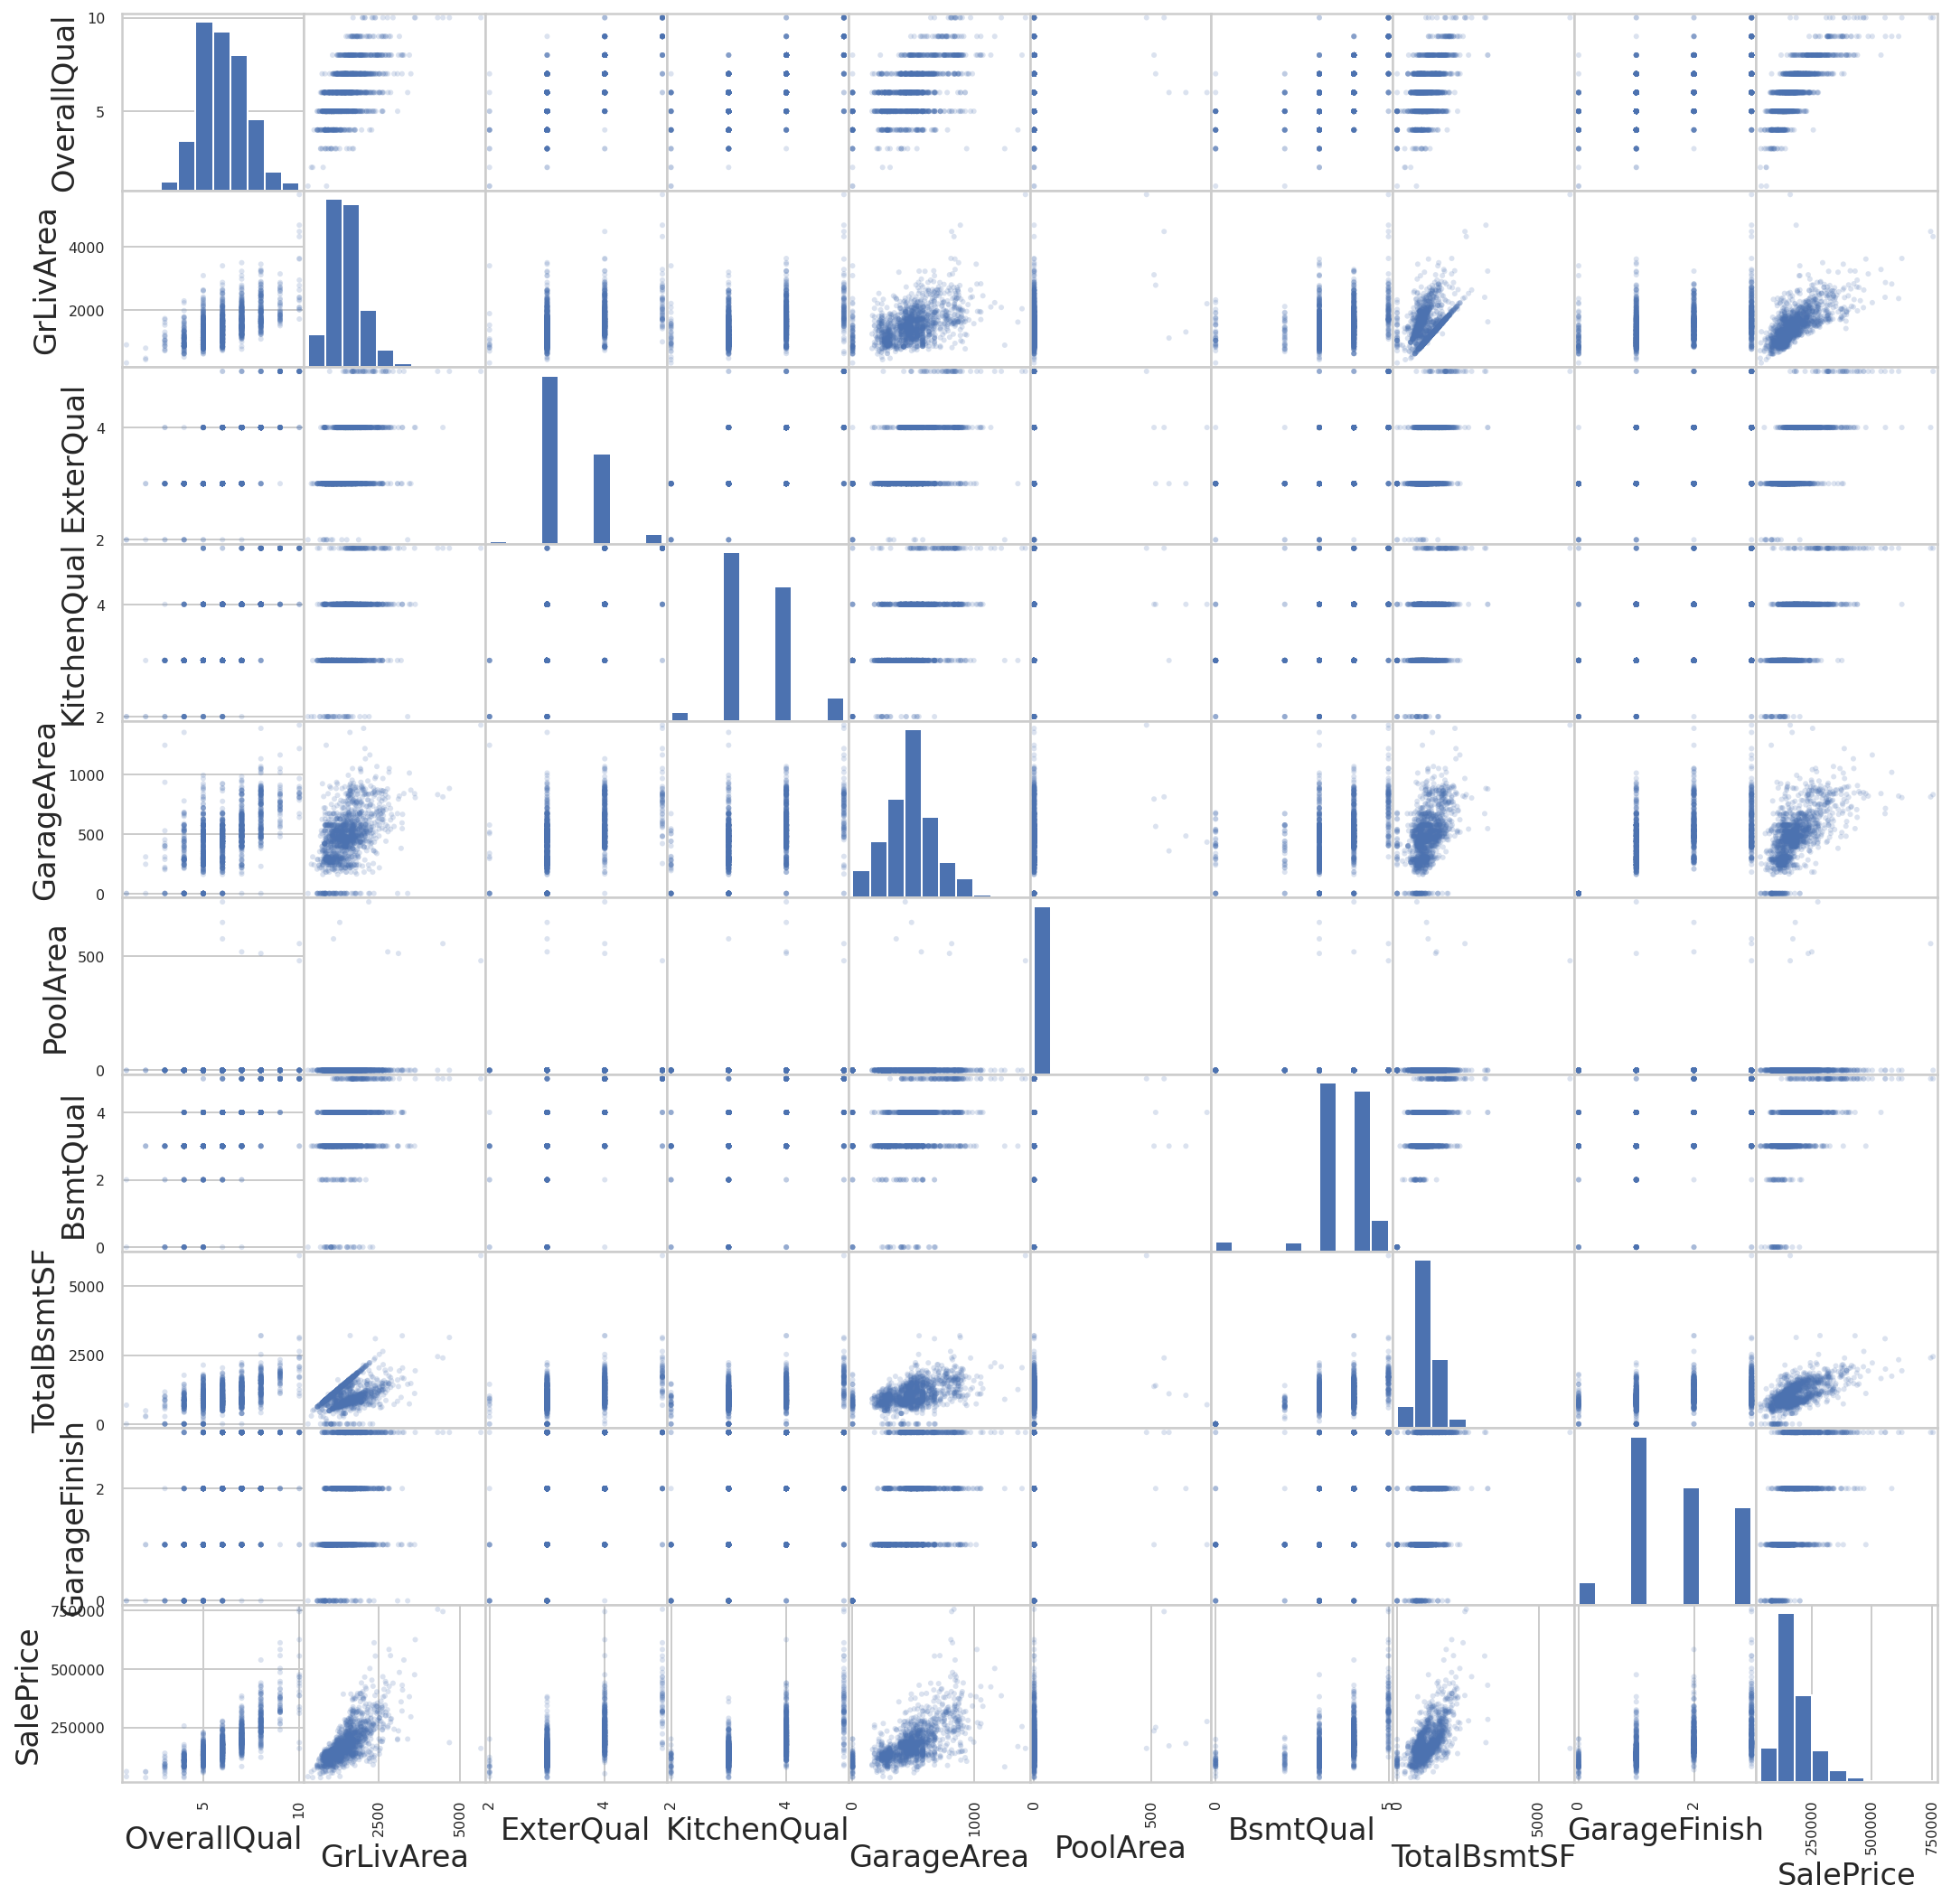

In [ ]:
pd.plotting.scatter_matrix(filtered_df, diagonal='hist', figsize=(18, 18), alpha=0.2)
plt.show()

### Как пользоваться линейными моделями

Как можно догадаться, на практике никто не пишет заново свои линейные модели. Для машинного обучения часто используют библиотеку scikit learn, для аналитики statsmodels. С первой вы познакомитесь (или уже познакомились) на курсе по ML, мы же сконцентрируемся на второй.

Итак, библиотека statsmodels состоит из множества реализованных критериев и, как ни странно, статистических моделей. Основным плюсом является то, что нам не нужно реализовывать критериии вручную, все сделано за нас (это не значит что думать не надо!).

Начнем с линейной модели: для того, чтобы ее создать понадобится лишь одна строка.  Как видно в ячейке ниже мы задаем формулу того, какую модель мы хотим получить. В данном случае мы хотим предсказать ``SalePrice`` по взвешенной сумме из остальных признаков.

In [ ]:
formula = "SalePrice ~ " + " + ".join(useful_columns[:-1])

print(formula)

SalePrice ~ OverallQual + GrLivArea + ExterQual + KitchenQual + GarageArea + PoolArea + BsmtQual + TotalBsmtSF + GarageFinish


Теперь эту формулу мы просто передаем в модель, а так же подаем ей данные. В формуле написаны имена колонок из ``filtered_df``. 

In [ ]:
simple_model = smf.ols(formula, data=filtered_df)

fitted_simple_model = simple_model.fit()

print(fitted_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     581.5
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        19:11:10   Log-Likelihood:                -17429.
No. Observations:                1460   AIC:                         3.488e+04
Df Residuals:                    1450   BIC:                         3.493e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.483e+05   6394.344    -23.185   

После работы кода должна, выше должна получится примерно такая картинка:

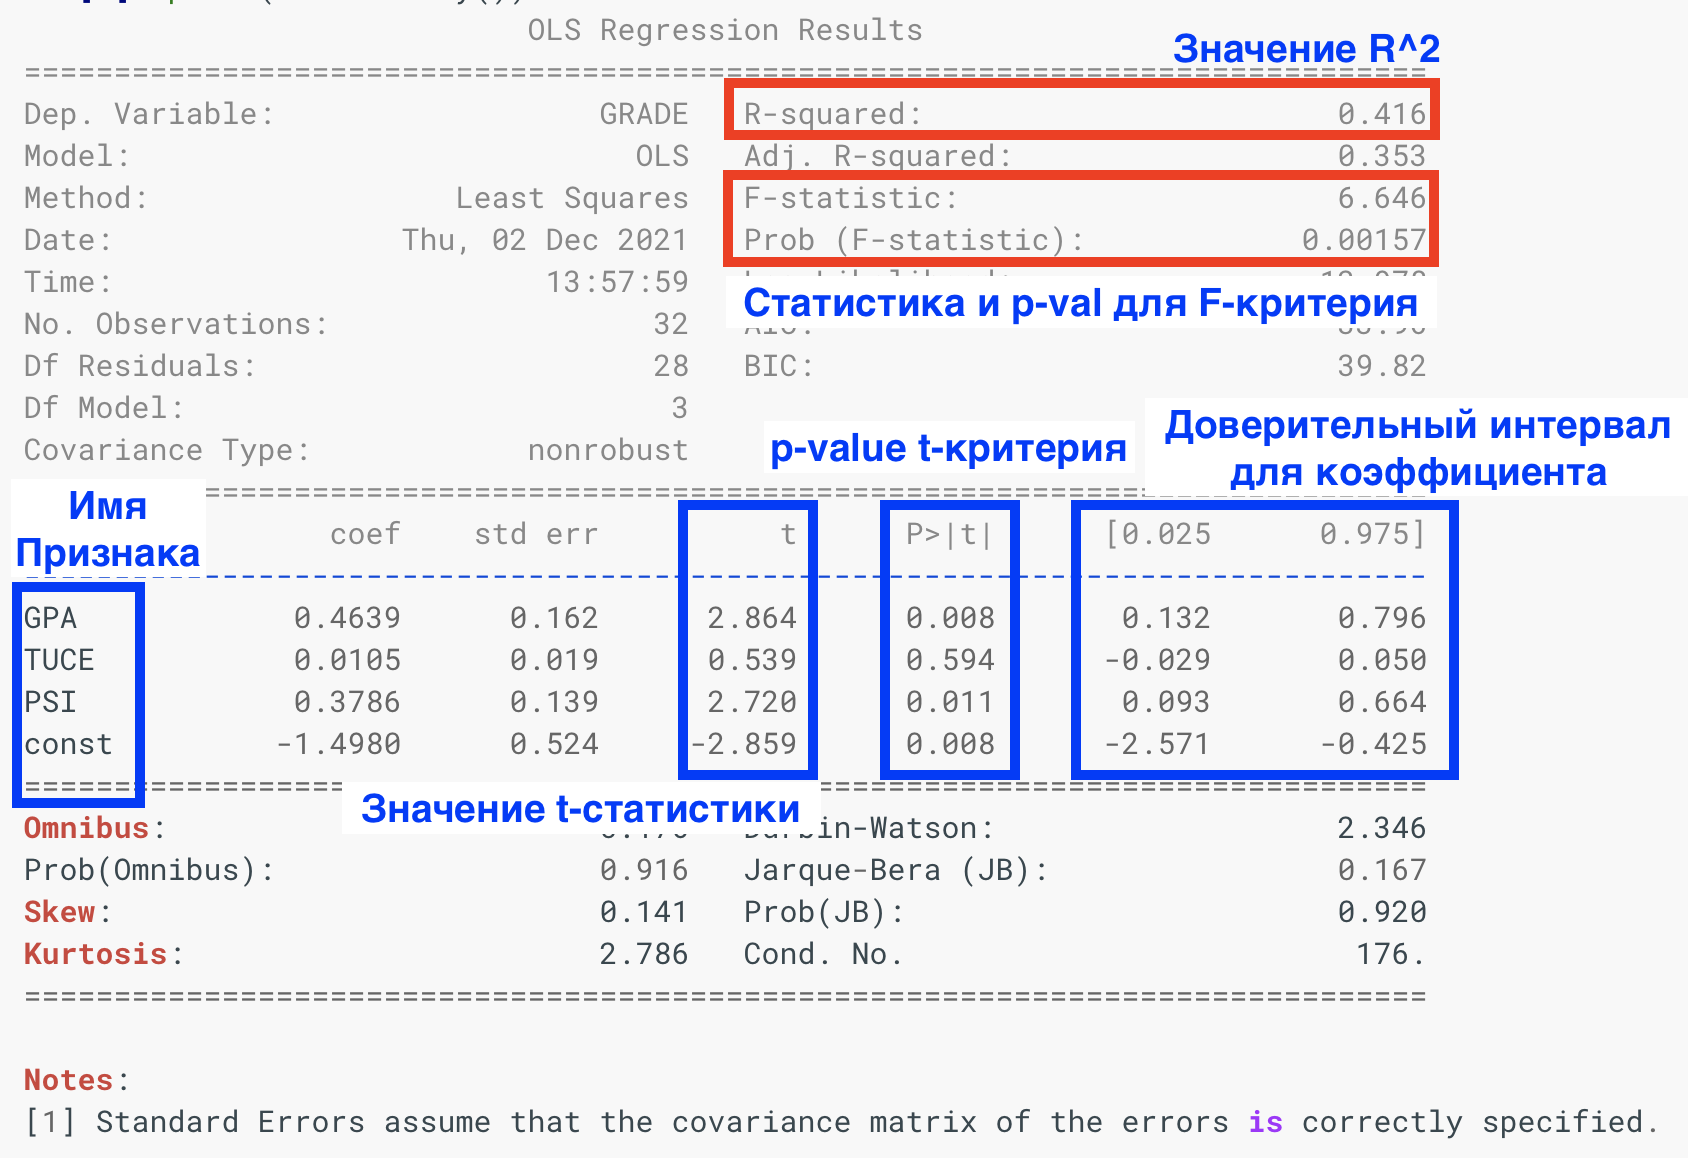


В примере название фичей намеренно изменены.

Можно заметить, что сверху располагается уже известный вам $R^2$. Далее чуть ниже располагются статистика и p-value (уровень достигаемой значимости) для F-критерия. Проверяется гипотеза о том, что наша модель работает лучше константы.

В мини-таблице есть проверка каждого признака на его значимость в модели с помощью t-критерия. Проверяется гипотеза о том, что модель без этого признака описывает не хуже, чем модель с этим признаком. Если значение p-value низкое, то, вероятно, признак статистически важен для модели. Таким образом можно осуществлять отбор признаков.




### Гетероскедастичность ошибки

Оценка, полученная с помощью гауссовской линейной модели будет справдлива лишь при выполнении условия гомоскедастичности остатков. Для проверки на гомоскедастичность часто используют критерий Бройша — Пагана. Мы не будем вдаваться в детали и доказательство того, что критерий валидный и работает правильно. Итак, критерий Бройша — Пагана проверяет нулевую гипотезу о гомоскедастичности распределения данных против альтернативы, то есть гетероскедастичности. Если нулевая гипотеза отвергается то можно сказать, что данные распределены ГЕТЕРОскедастично. Мы этого не хотим.

Критерий реализован с помощью функции ``sms.diagnostic.het_breuschpagan``. Документацию можно найти [здесь](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html).

Остатки модели можно из поля ``fitted_model.resid``, а параметры из ``fitted_model.model.exog``.

Нас интересует p-value для множителя Лагранжа.

В ячейке ниже получите уровень достигаемой значимости для критерия Бройша — Пагана.

In [ ]:
p_val_het = sms.diagnostic.het_breuschpagan(resid=fitted_simple_model.resid, exog_het=fitted_simple_model.model.exog)[1]

print(f"p-value simple: {p_val_het}")

p-value simple: 5.431361130993936e-95


Отвергается ли гипотеза о гомоскедастичности остатков? Что это озночает?

**Ответ:** p-value - это вероятность истинности нулевой гипотезы. Значение мало,значит, гипотеза отвергается. И дисперсия случайных величин (цена на дома) непостоянна на нашем наборе данных.

В случаях, когда распределения остатков не является гомоскедастичном оценка по-прежнему остается несмещенной, однако стоит сделать некоторую поправку, на более высокую дисперсию. Поэтому значения F-критериев и t-критериев для коэффициентов стоит пересмотреть. Для таких случаев существует достаточно много различных поправок, одно из семейств таких поправок называется поправки Уайта на гетероскедастичность. Ниже мы попробуем использовать одну из поправок.

Для этого, в ячейке ниже, обучите линейную модель, но на этот раз передайте в метод ``.fit`` аргумент ``cov_type="HC1"``.

Получите summary для такой модели.

In [ ]:
simple_model = smf.ols(formula, data=filtered_df)
fitted_simple_model = simple_model.fit(cov_type="HC1")

print(fitted_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     266.7
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          5.44e-300
Time:                        19:51:33   Log-Likelihood:                -17429.
No. Observations:                1460   AIC:                         3.488e+04
Df Residuals:                    1450   BIC:                         3.493e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.483e+05   9507.281    -15.594   

Проанализируйте результаты. Как изменились p-value для t-критериев? Как изменился коэффициент $R^2$?

**Ответ:** p-value увеличились для некоторых признаков, коэффициент $R^2$ не изменился

Теперь мы действительно можем оценивать то, насколько важен тот или иной признак. Давайте отфильтруем наш датасет и оставим в нем только значимые признаки на уровне значимости $\alpha = 0.05$. (используйте t-критерий).



In [ ]:
features_to_filter = ["PoolArea"]

filtered_columns = useful_columns

for f_t_f in features_to_filter:
    idx_to_filter = useful_columns.index(f_t_f)
    filtered_columns.pop(idx_to_filter)


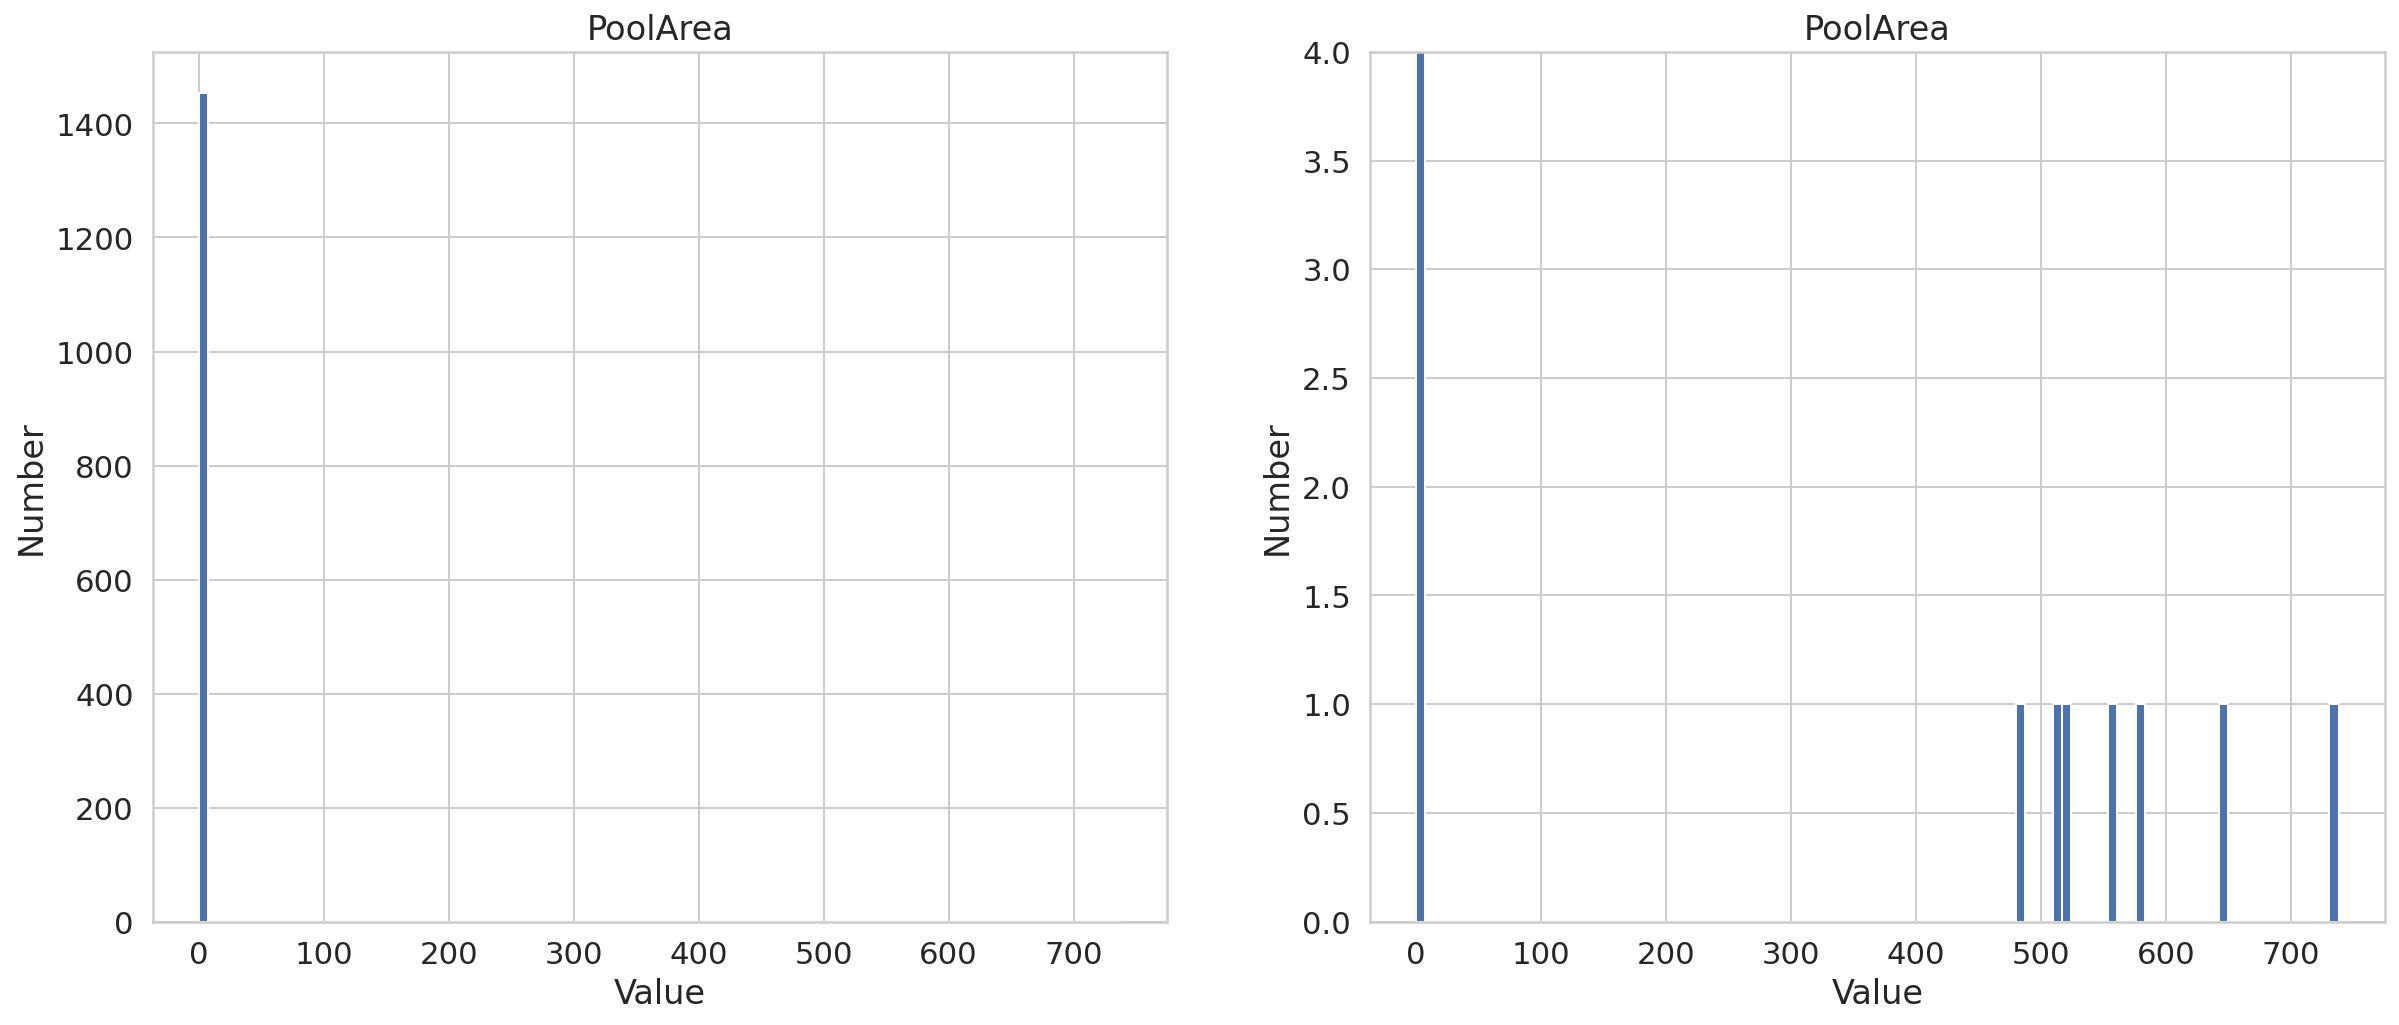

In [ ]:
# Посмотрим отдельно на гистограмму для этого признака
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].set_title("PoolArea")
ax[0].hist(filtered_df["PoolArea"], bins=100)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Number")

ax[1].set_title("PoolArea")
ax[1].hist(filtered_df["PoolArea"], bins=100)
ax[1].set_ylim(0, 4)
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Number")

plt.show()

Какие признаки оказались не значимы и почему?

**Ответ: площадь бассейна, так как мало домов с бассейнами**

Теперь снова обучим новую модель только на значимых признаках и получим summary. Не забудьте про поправку Уайта!

In [ ]:

filtered_formula = "SalePrice ~ " + " + ".join(filtered_columns[:-1])

filtered_model = smf.ols(filtered_formula, data=filtered_df[filtered_columns])
fitted_filtered_model = filtered_model.fit(cov_type="HC1")

print(fitted_filtered_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     300.1
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          4.12e-301
Time:                        20:32:20   Log-Likelihood:                -17429.
No. Observations:                1460   AIC:                         3.488e+04
Df Residuals:                    1451   BIC:                         3.492e+04
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -1.48e+05   9707.685    -15.247   

Как изменился коэффициент $R^2$? Всегда ли бОльший $R^2$ говорит о правильной модели? Расскажите о своих рассуждениях!

**Ответ:** коэффициент $R^2$ не изменился. $R^2 =1-\frac {D[y|x]}{D[y]}=1-\frac {\sigma^2}{\sigma^2_y}$, где $\sigma^2$ - дисперсия ошибки модели. Есть факт, что при увеличении числа переменных в регрессии коэф-т не может уменьшиться. Насколько я понимаю интуицию происходящего: Чем больше признаков мы добавляем в нашу модель, тем меньше будет дисперсия ошибки (дисперсия нужной нам случайной величины будет полностью объясняться выбранными признаками(переменными в уравнении регрессии), так как условно мы рассмотрим все возможные признаки, которые могут как-то влиять). Но может это и не так... В любом случае, получается, что этот коэффициент корректно сравнивать только у моделей с одинаковым числом признаков(переменных).

### Преобразование целевого признака

Обратим свое внимание на целевую переменную. Ниде постройте гистограммы для признака ``SalePrice``. А так же для логарифма от ``SalePrice``. Сделайте это на разных картинках. Можно использовать subplot.

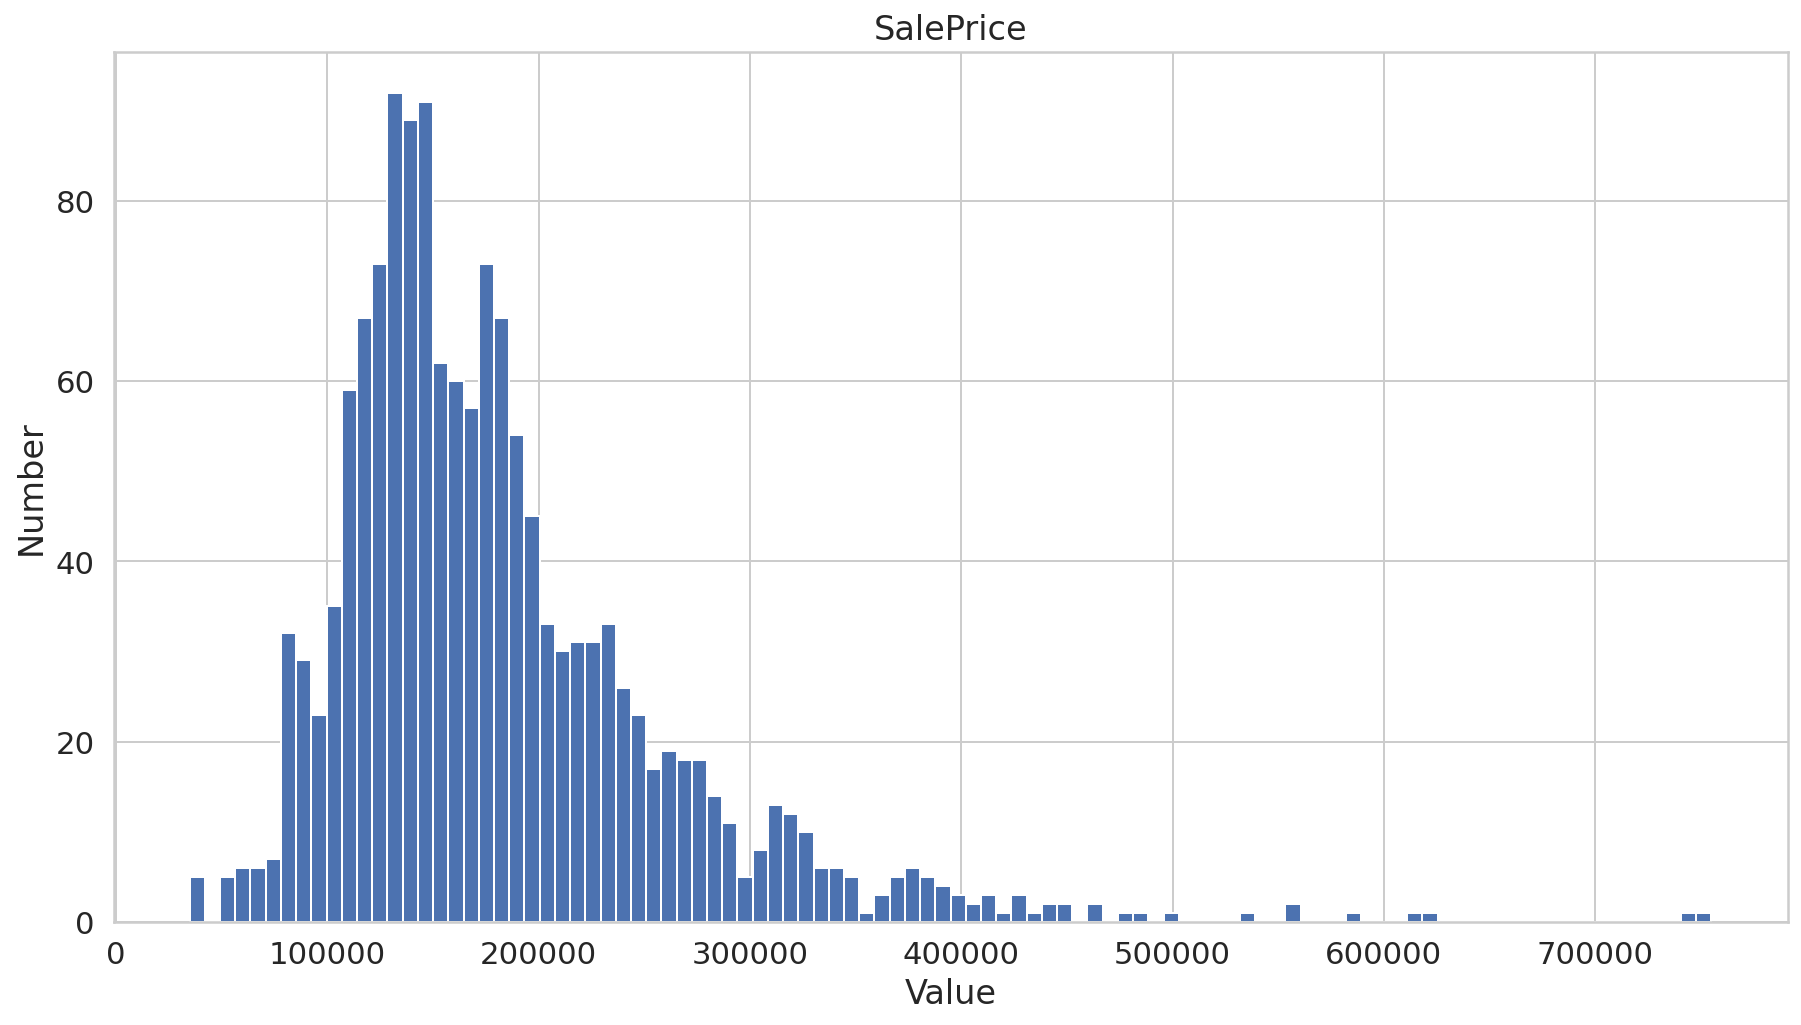

In [ ]:
plt.figure(figsize=(15,8))
plt.title("SalePrice")
plt.hist(filtered_df["SalePrice"], bins=100)
plt.xlabel("Value")
plt.ylabel("Number")
plt.show()

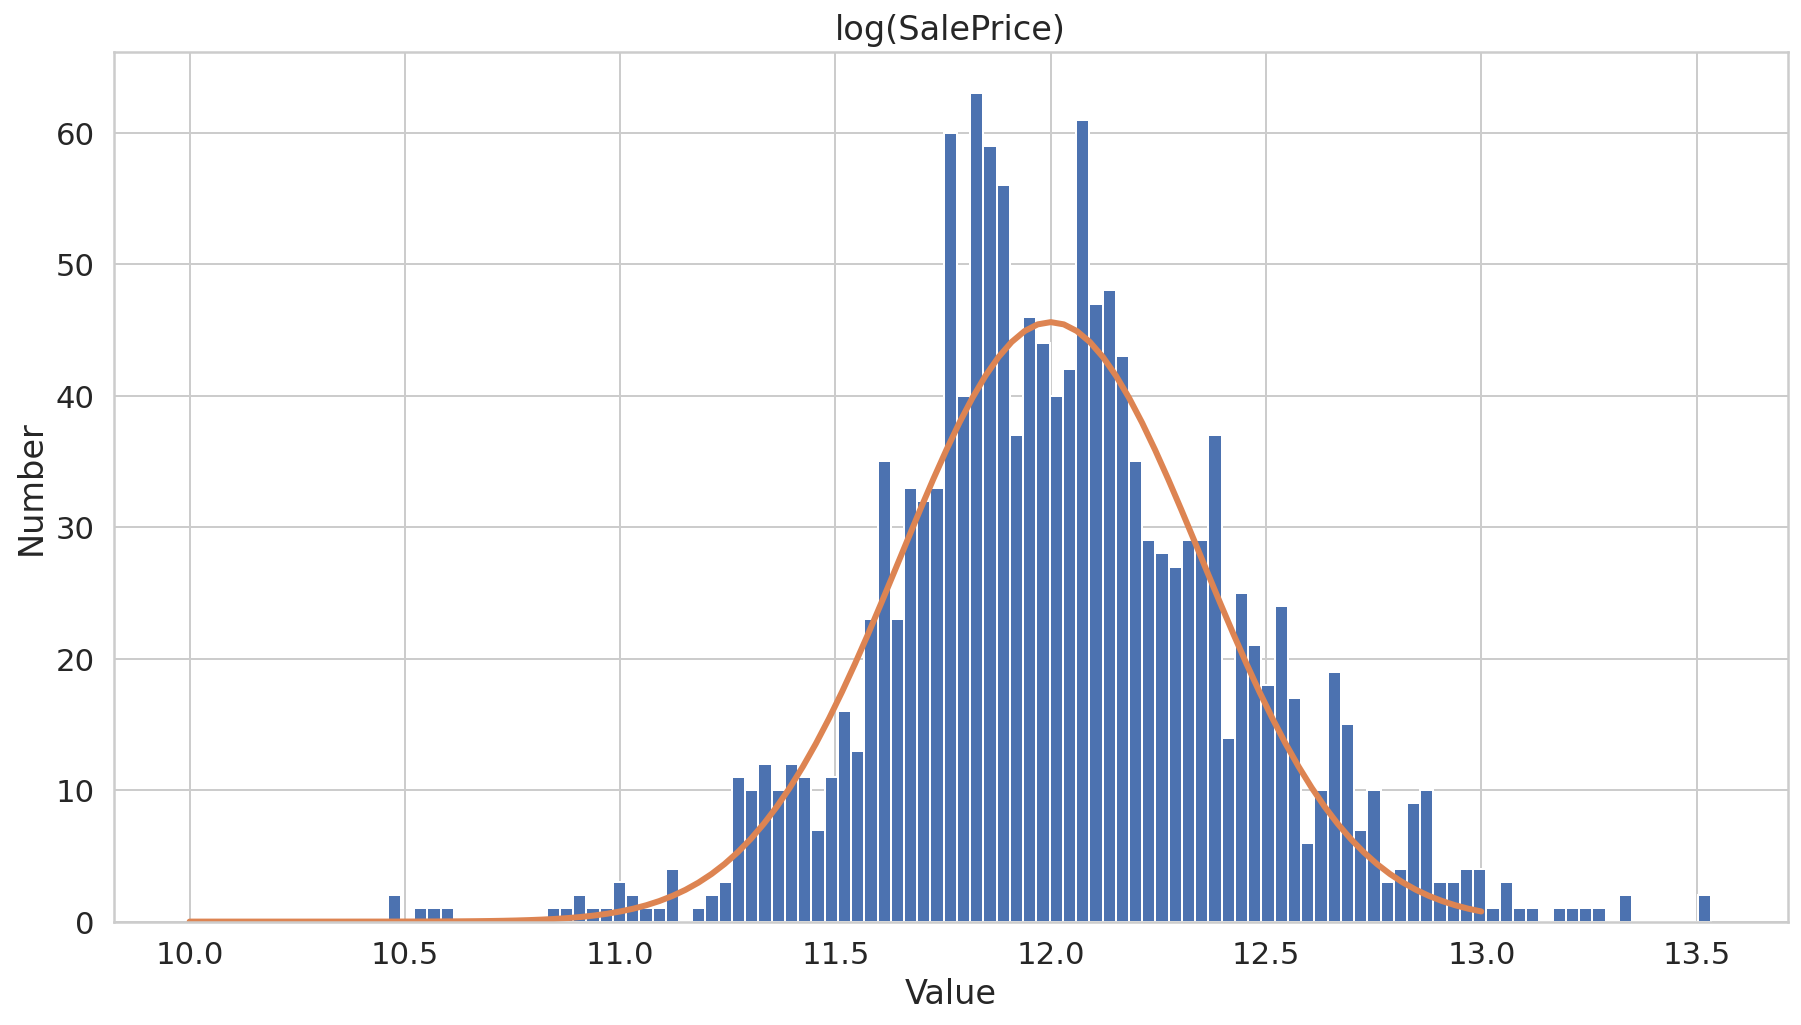

In [ ]:
import scipy.stats as sps

plt.figure(figsize=(15,8))
plt.title("log(SalePrice)")
plt.hist(np.log(filtered_df["SalePrice"]), bins=100, label="sample hist")
plt.xlabel("Value")
plt.ylabel("Number")

grid = np.linspace(10, 13, 100)  
plt.plot(grid, sps.norm(loc=12, scale=0.35).pdf(grid)*40, lw=3, label='some Gaussian distribution')

plt.show()

Какой из графиков выглядит более "Гауссовским"?

**Ответ:** второй

Теперь давайте снова посмотрим на распределение остатков от линейной модели. Начертим qqplot для нормального распределения и гистограмму остатков.

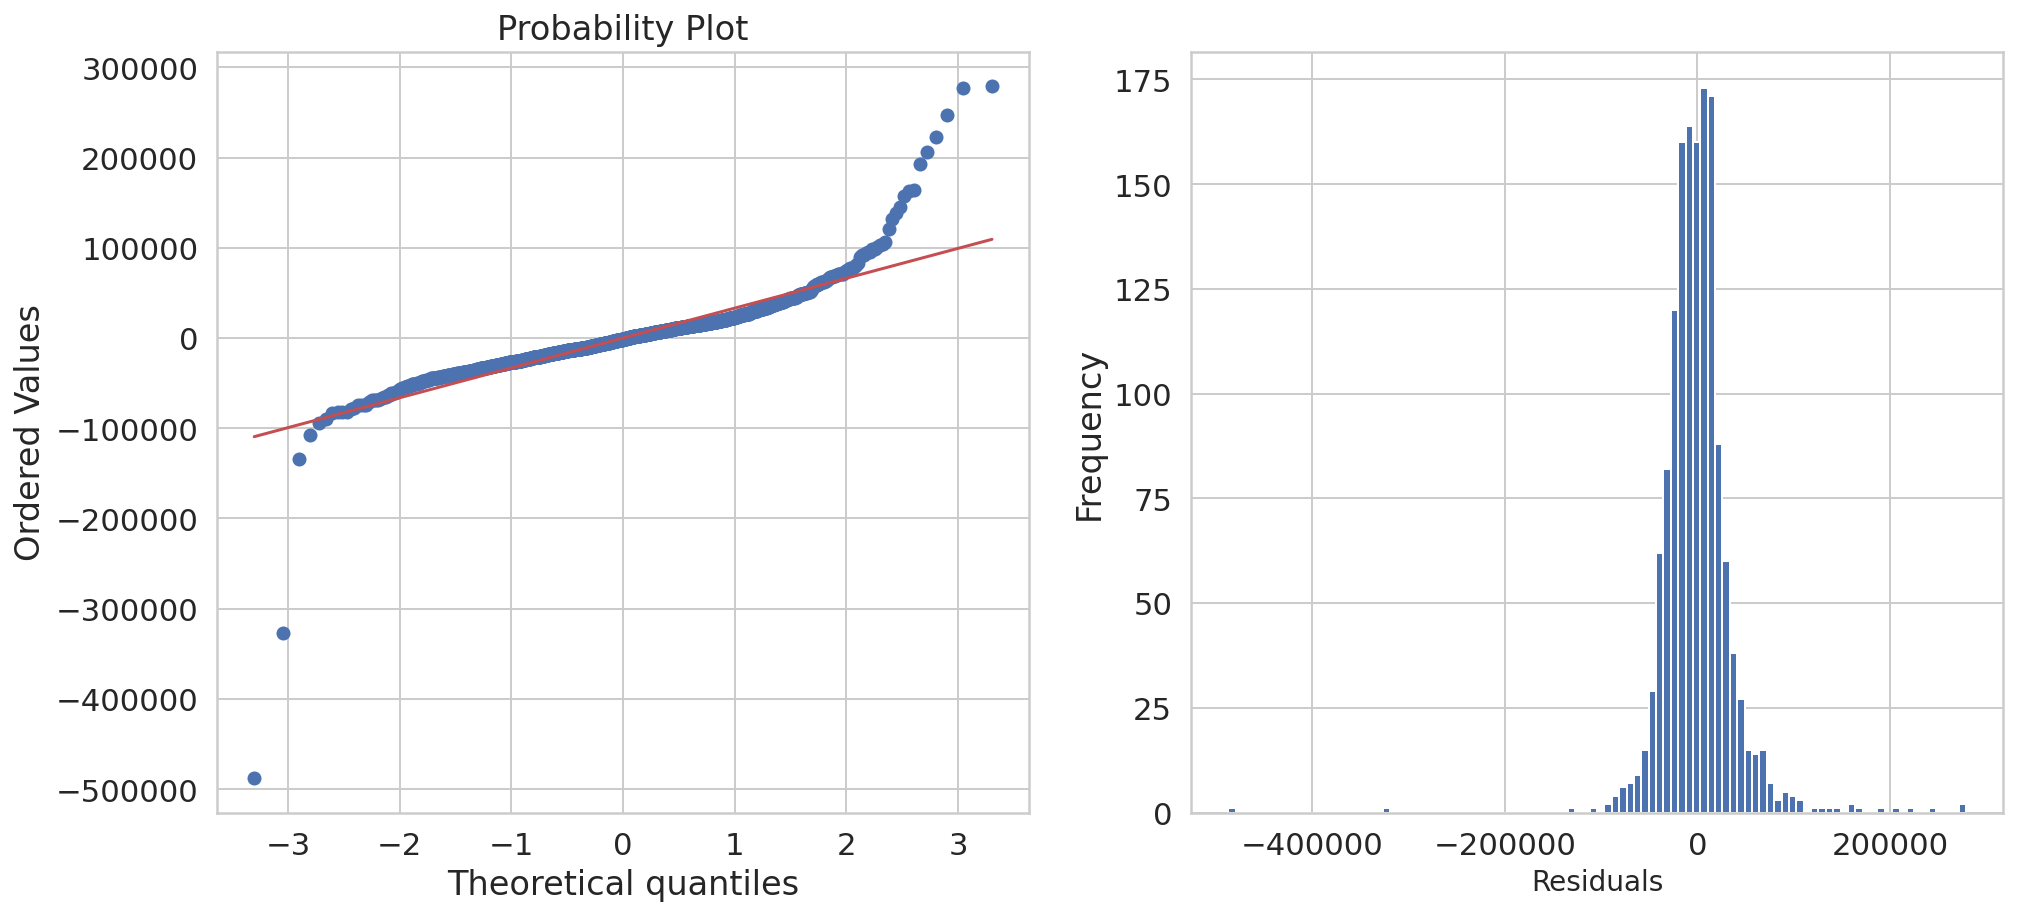

In [ ]:
import scipy

plt.figure(figsize=(16,7))
plt.subplot(121)
scipy.stats.probplot(fitted_filtered_model.resid, dist="norm", plot=plt)
plt.subplot(122)
fitted_filtered_model.resid.plot.hist(bins=100)
plt.xlabel('Residuals', fontsize=14)
plt.show()

Как вы считаете, можно ли сказать, что распределение остатков это нормальное распределение?

**Ответ:** если не учитывать выбросы, то можно (по крайней мере графики показывают так)

Давайте обучим модель предсказывать не SalePrice, а ее логарифм. Для этого снова обновим формулу для модели. Прелесть формул в том, что в них можно использовать операции из numpy. Например можно искать зависимость не от ``PoolArea``, а от ее квадрата, то есть ``np.power(PoolArea, 2)``. Достаточно просто добавить в формулу ..." + np.power(PoolArea, 2)" и все заработает!

В ячейке ниже обучите модель предсказывать логарифм SalePrice. Получите summary этой модели.

In [ ]:
log_formula = "np.log(SalePrice) ~ " + " + ".join(filtered_columns[:-1])

log_model = smf.ols(log_formula, data=filtered_df)
fitted_log_model = log_model.fit(cov_type="HC1")

print(fitted_log_model.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     599.1
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:59:34   Log-Likelihood:                 499.69
No. Observations:                1460   AIC:                            -981.4
Df Residuals:                    1451   BIC:                            -933.8
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.4070      0.035    298.718   

Как изменился коэффициент R^2? Модель лучше стала понимать данные?

**Ответ:** коэффициент увеличился при равном количестве переменных, значит, модель стала лучше.

Постройте графики, аналогичные тем, что встретились нам на две ячейки выше (qqplot и гистограмму остатков). Но на этот раз для модели, предсказывающией логарифм. 

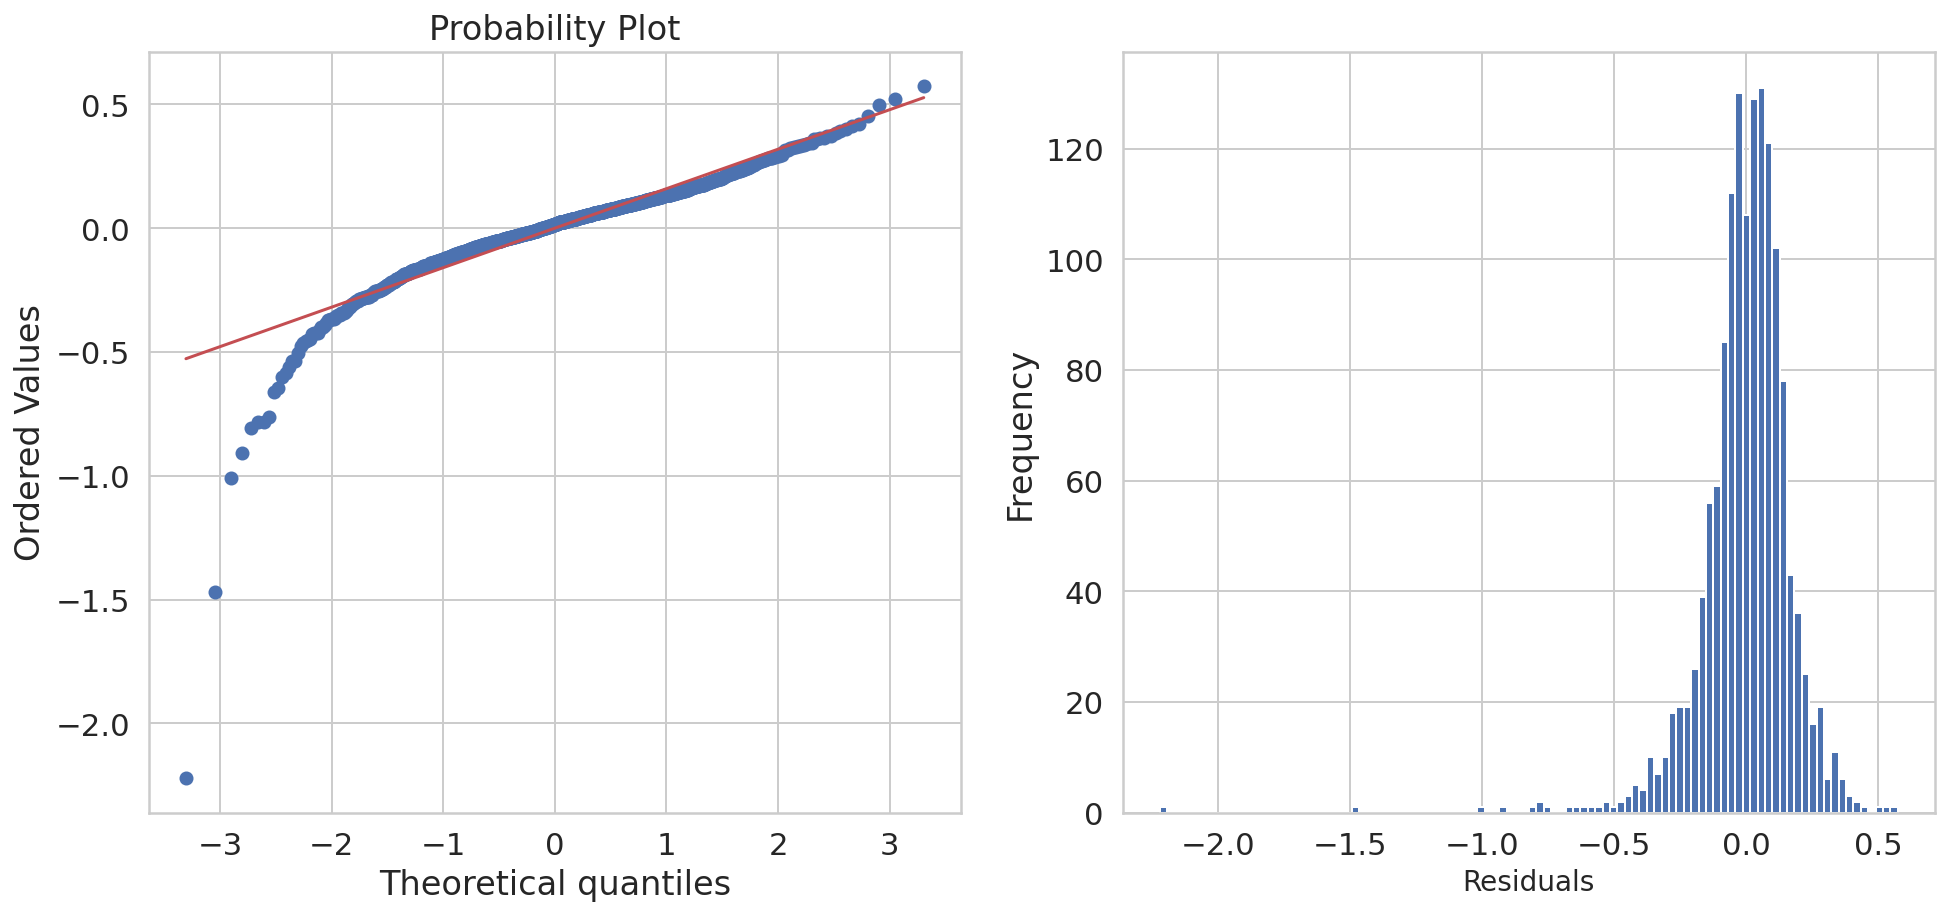

In [ ]:
plt.figure(figsize=(16,7))
plt.subplot(121)
scipy.stats.probplot(fitted_log_model.resid, dist="norm", plot=plt)
plt.subplot(122)
fitted_log_model.resid.plot.hist(bins=100)
plt.xlabel('Residuals', fontsize=14)
plt.show()

Как вы считаете, стоит ли предсказывать логарифм от цены? В каких случаях это полезно?

**Ответ:** Например, когда модель нелинейная. А, взяв логарифм зависимой переменной, сможем с помощью линейной регрессии найти нелинейную зависимость ($ln(y)=a+bx \Rightarrow y=e^ae^{bx}=ke^{bx}$). 

Еще таким образом можно как бы позволить бОльший диапазон коэффициентов. То есть: если увеличить переменную-признак (х) на 1, то с логарифмированием это изменение внесет больший вклад в у (у увеличится на е). Тогда веса будут меньше по модулю.